# 1. VERİ YOLU VE KÜTÜPHANELERİN YÜKLENMESİ

### 1.1- Data Setlerimizin Yolu:

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 - Gerekli Kütüphaneler

In [27]:
import numpy as np
from skimage import exposure, filters
import matplotlib.pyplot as plt
import os
from skimage.feature import hog, local_binary_pattern
from sklearn.mixture import GaussianMixture
from shapely.geometry import Polygon
import cv2
from brisque import BRISQUE  # BRISQUE skoru için

# 2. ÖN İŞLEME (Skor)
## Pipeline 1: Min-Max Norm + Sobel Keskinleştirme + Gürültü Azaltma + Histogram Eşitleme + Gamma Dönüşümü

### 2.1 Ön işleme yöntemlerinin oluşturulması

En iyi Pipeline: 1 (BRISQUE Skoru: 18.81)


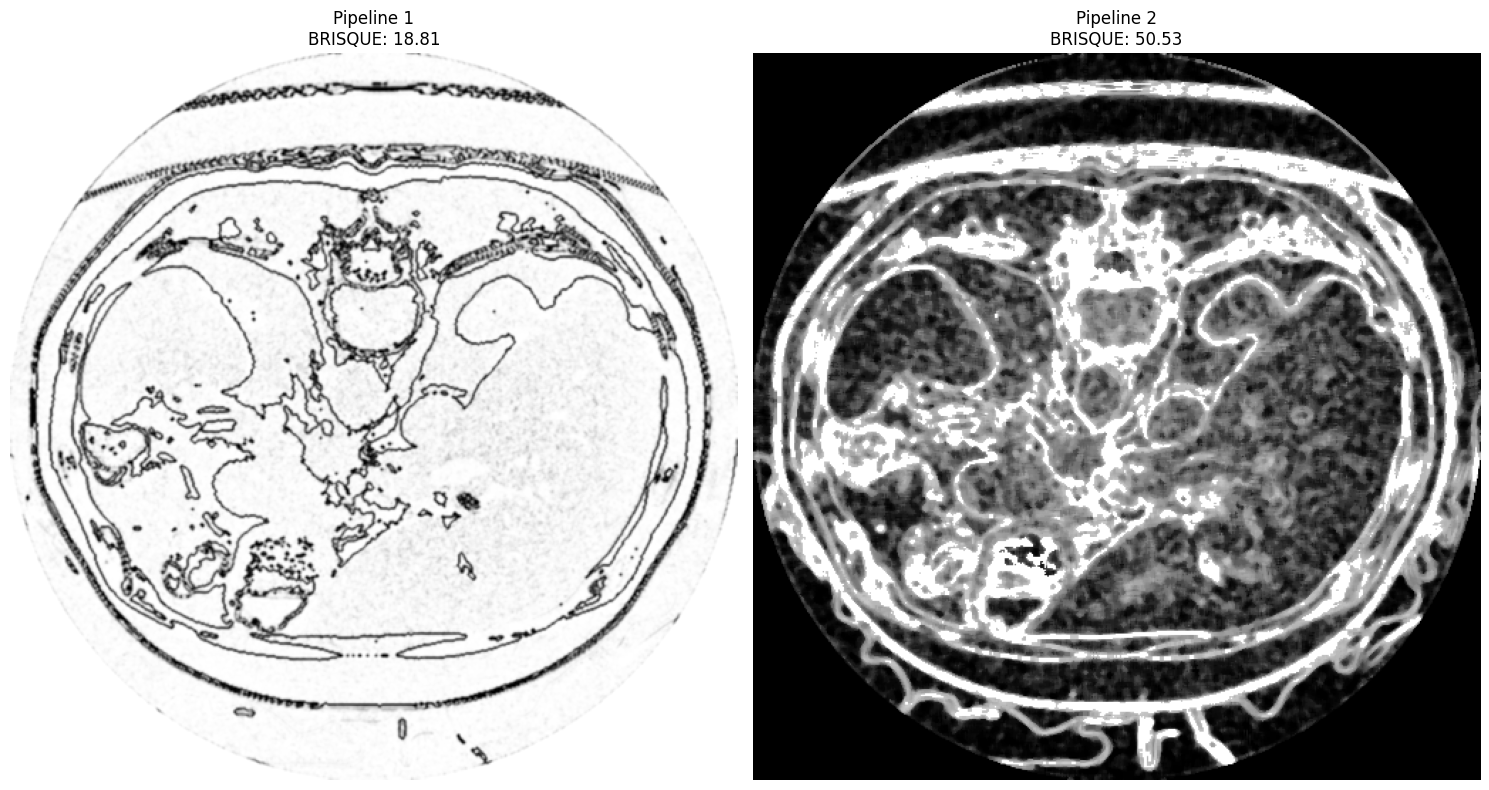

In [28]:


# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    else:
        raise ValueError("Unsupported normalization method")

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0

# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Canny Keskinleştirme fonksiyonu
def canny_sharpen(image):
    return cv2.Canny(image, 40, 90)  # Min-Max threshold (40, 90)

# Laplacian Keskinleştirme
def laplacian_sharpen(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Unsharp Mask fonksiyonu
def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 8.0)
    return cv2.addWeighted(image, 1.2, blurred, -0.2, 0)

# Bilateral Filtre fonksiyonu
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 30, 30)

# Adaptive Histogram Eşitleme uygulama
def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Pipeline fonksiyonları
def apply_pipeline(image, pipeline):
    if pipeline == 1:
        # Pipeline 1: Min-Max Norm + Adaptive Histogram Eşitleme + Laplacian Keskinleştirme + Gaussian Blur + Gamma Dönüşümü
        norm_image = normalize(image, method="minmax")
        adaptive_hist_eq_image = apply_adaptive_histogram_equalization((norm_image).astype(np.uint8))
        laplacian_image = laplacian_sharpen(adaptive_hist_eq_image)
        smoothed_image = cv2.GaussianBlur(laplacian_image, (3, 3), 0)
        final_image = apply_gamma(smoothed_image, gamma=1.8).astype(np.uint8)  # Daha parlak sonuç

        # Siyah ve beyaz renkleri tersine çevirme
        final_image = cv2.bitwise_not(final_image)  # Siyah ve beyazın tersini al

    elif pipeline == 2:
        # Pipeline 2: Min-Max Norm + Sobel Keskinleştirme + Median Blur + Histogram Eşitleme + Gamma Dönüşümü
        norm_image = normalize(image, method="minmax")
        sobel_image = sobel_sharpen((norm_image).astype(np.uint8))
        smoothed_image = cv2.medianBlur(sobel_image, 5)  # Daha güçlü Denoising
        final_image = cv2.equalizeHist(smoothed_image)  # Histogram Eşitleme
        final_image = apply_gamma(final_image, gamma=1.2).astype(np.uint8)  # Orta düzeyde parlaklık

    else:
        raise ValueError("Unsupported pipeline")

    return final_image

# Pipeline'ları değerlendirme
def main_pipeline_evaluation(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Görüntü yüklenemedi: {image_path}")

    pipelines = [1, 2]
    results = {}

    for pipeline in pipelines:
        # Pipeline'ı uygula
        processed_image = apply_pipeline(image, pipeline)

        # BRISQUE metriği ile değerlendirme
        processed_image_3_channel = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
        brisque_score = BRISQUE().score(processed_image_3_channel)
        results[pipeline] = (processed_image, brisque_score)

    # En iyi pipeline'ı seç
    best_pipeline = min(results, key=lambda x: results[x][1])
    print(f"En iyi Pipeline: {best_pipeline} (BRISQUE Skoru: {results[best_pipeline][1]:.2f})")

    # Görüntüleri gösterme
    plt.figure(figsize=(15, 10))
    for i, pipeline in enumerate(pipelines, start=1):
        plt.subplot(1, len(pipelines), i)
        plt.title(f"Pipeline {pipeline}\nBRISQUE: {results[pipeline][1]:.2f}")
        plt.imshow(results[pipeline][0], cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Kullanım
image_path = "/content/drive/MyDrive/images/FLARE22_Tr_0001_slice_60.png"  # Görüntü yolunu doğru ayarlayın
main_pipeline_evaluation(image_path)


In [29]:
# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        raise ValueError("Unsupported normalization method")


# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0


### 2.2 Ön İşlemenin Uygulanması

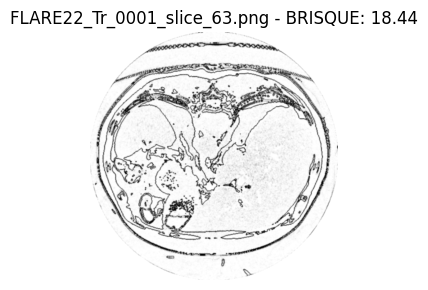

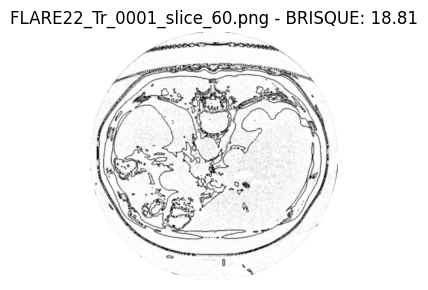

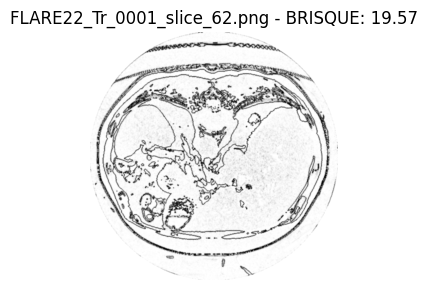

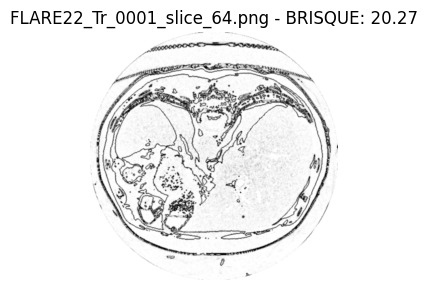

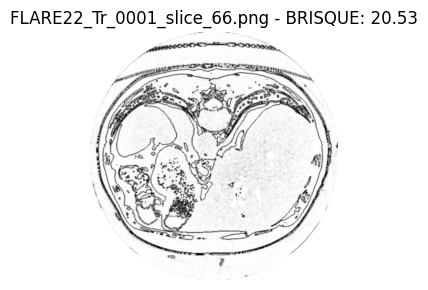

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from brisque import BRISQUE  # BRISQUE'yi doğru şekilde içe aktardığınızı varsayıyorum

# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    else:
        raise ValueError("Unsupported normalization method")

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0

# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Canny Keskinleştirme fonksiyonu
def canny_sharpen(image):
    return cv2.Canny(image, 40, 90)  # Min-Max threshold (40, 90)

# Laplacian Keskinleştirme
def laplacian_sharpen(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Unsharp Mask fonksiyonu
def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 8.0)
    return cv2.addWeighted(image, 1.2, blurred, -0.2, 0)

# Bilateral Filtre fonksiyonu
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 30, 30)

# Adaptive Histogram Eşitleme uygulama
def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Pipeline fonksiyonları
def apply_pipeline(image):
    # Pipeline 1: Min-Max Norm + Adaptive Histogram Eşitleme + Laplacian Keskinleştirme + Gaussian Blur + Gamma Dönüşümü
    norm_image = normalize(image, method="minmax")
    adaptive_hist_eq_image = apply_adaptive_histogram_equalization((norm_image).astype(np.uint8))
    laplacian_image = laplacian_sharpen(adaptive_hist_eq_image)
    smoothed_image = cv2.GaussianBlur(laplacian_image, (3, 3), 0)
    final_image = apply_gamma(smoothed_image, gamma=1.8).astype(np.uint8)  # Daha parlak sonuç

    # Siyah ve beyaz renkleri tersine çevirme
    final_image = cv2.bitwise_not(final_image)  # Siyah ve beyazın tersini al

    return final_image

# Görüntüyü değerlendirme fonksiyonu
def evaluate_image(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Görüntü yüklenemedi: {image_path}")

    # Pipeline'ı uygula
    processed_image = apply_pipeline(image)

    # BRISQUE metriği ile değerlendirme
    processed_image_3_channel = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
    brisque_score = BRISQUE().score(processed_image_3_channel)

    return brisque_score, processed_image

# Belirtilen dizindeki ilk 100 görüntüyü işleme fonksiyonu
def evaluate_images_in_directory(directory_path):
    scores = []  # Skorları tutacak liste

    count = 0
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Sadece görüntü dosyalarını işleme al
            image_path = os.path.join(directory_path, filename)
            brisque_score, processed_image = evaluate_image(image_path)
            scores.append((brisque_score, processed_image, filename))  # Skor ve görüntüyü kaydet

            count += 1

            if count >= 50:  # Sadece ilk 50 görüntüyü işle
                break

    # En düşük BRISQUE skoruna sahip olanları sıralama ve en düşük 5'u alma
    lowest_scores = sorted(scores, key=lambda x: x[0])[:5]

    return lowest_scores

# Kullanım
directory_path = "/content/drive/MyDrive/images"
big5img = evaluate_images_in_directory(directory_path)

# En düşük skora sahip görüntüleri gösterme
for score, image, filename in big5img:
    plt.figure(figsize=(3, 3))
    plt.title(f"{filename} - BRISQUE: {score:.2f}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# 3. Desen Kodlama

### 3.1 En iyi 3 görselin ve labeli ile noktasal çarpımı

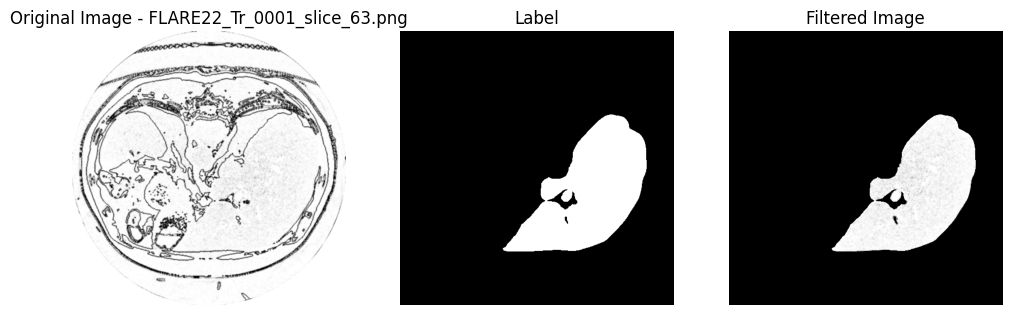

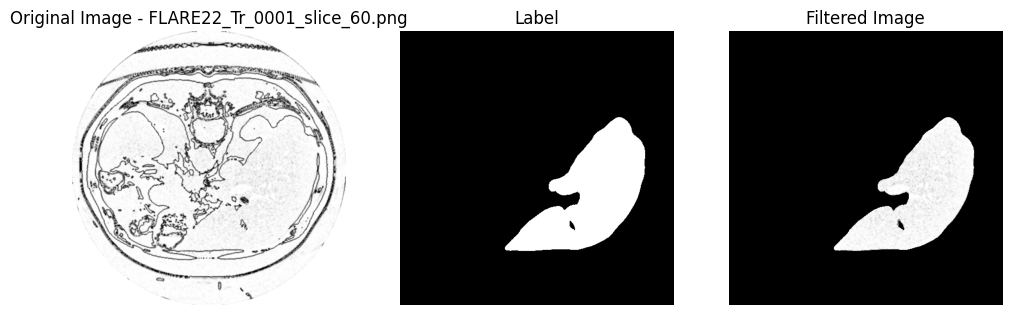

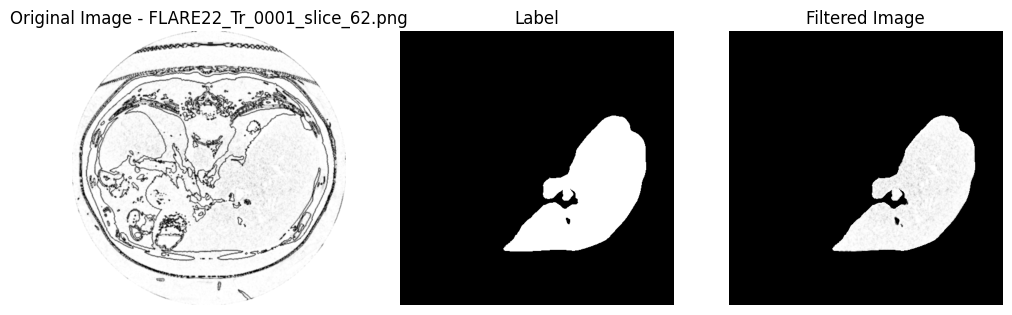

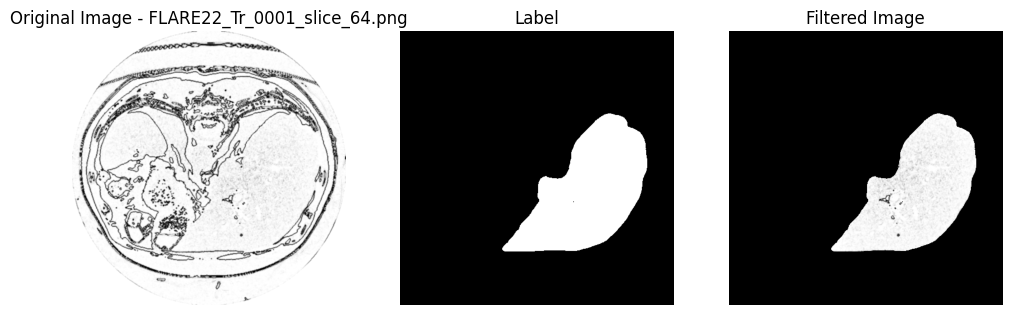

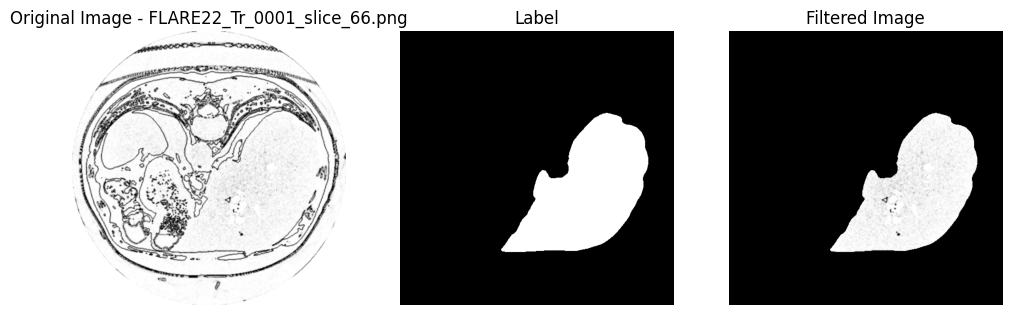

In [31]:
# Görsel ve label eşleştirme fonksiyonu
def process_big5img(lowest_scores, label_directory):
    count = 0
    for score, image, filename in lowest_scores:
        count += 1

        # Etiketi eşleştir
        label_path = os.path.join(label_directory, filename)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if label is None:
            print(f"Warning: Label not found for {filename}")
            continue

        # Normalize label (0 veya 1'e dönüştür)
        label = (label > 0).astype(np.uint8)
        filtered_image = cv2.bitwise_and(image, image, mask=label)

        # Görselleri çizdir
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image - {filename}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Filtered Image")
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')

        plt.show()
        if count >= 5:  # Sadece ilk 5 görüntüyü işle
            break

# Label dizini
label_directory_path = "/content/drive/MyDrive/labels"

# En düşük BRISQUE skorlarına sahip görsellerle işlem yap
process_big5img(big5img, label_directory_path)


### 3.2 Kullanılacak metodların oluşturulması

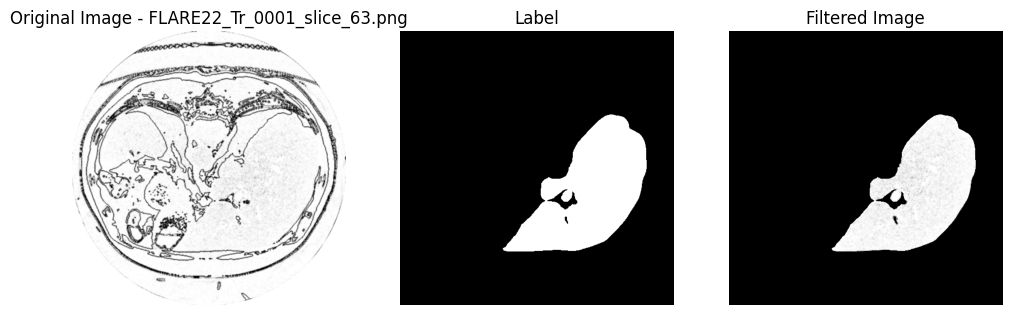

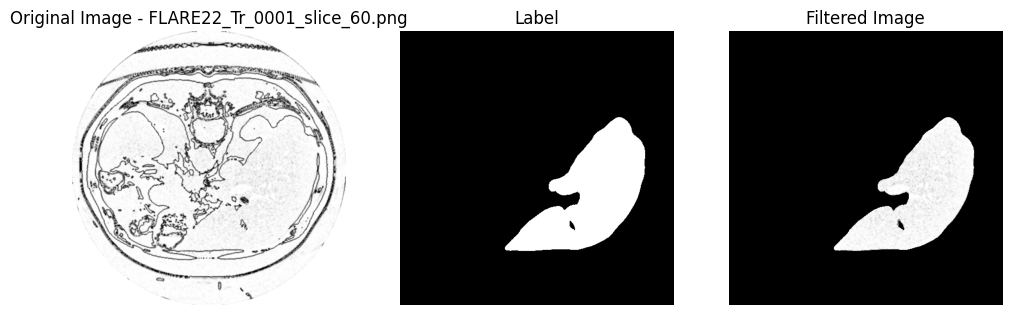

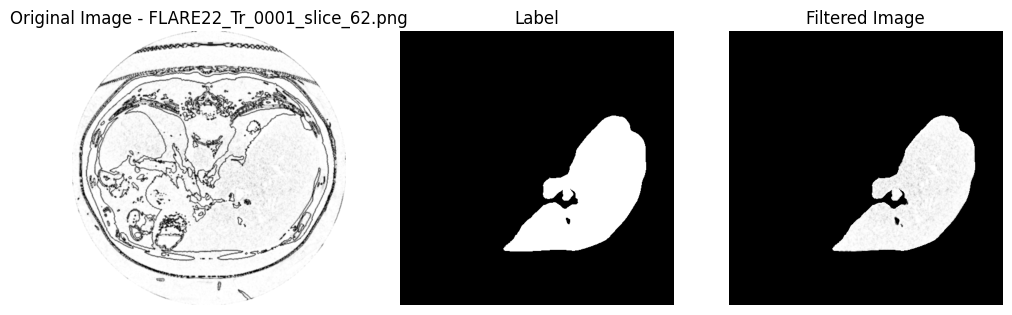

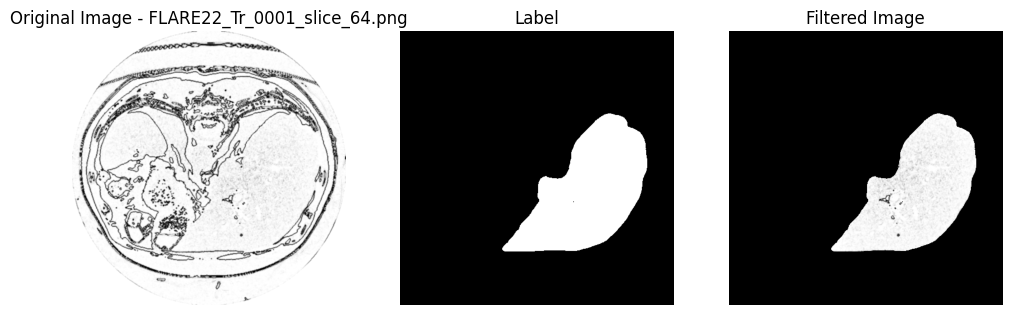

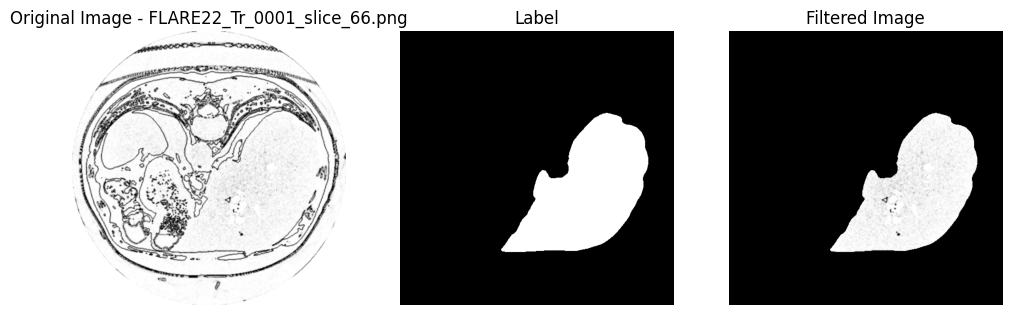

In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_big5img(lowest_scores, label_directory, output_directory):
    count = 0
    for score, image, filename in lowest_scores:
        count += 1

        # Etiketi eşleştir
        label_path = os.path.join(label_directory, filename)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if label is None:
            print(f"Warning: Label not found for {filename}")
            continue

        # Normalize label (0 veya 1'e dönüştür)
        label = (label > 0).astype(np.uint8)
        filtered_image = cv2.bitwise_and(image, image, mask=label)

        # Görselleri çizdir
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image - {filename}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Filtered Image")
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')

        plt.show()

        # Kaydetmek için filtered_image'ı output dizinine yaz
        output_path = os.path.join(output_directory, f"filtered_{filename}")
        cv2.imwrite(output_path, filtered_image)

        if count >= 5:  # Sadece ilk 5 görüntüyü işle
            break

# Label dizini
label_directory_path = "/content/drive/MyDrive/labels"
# Filtrelenmiş görsellerin kaydedileceği dizin
output_directory_path = "/content/drive/MyDrive/filtered_images"

# Eğer output dizini mevcut değilse oluştur
if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# En düşük BRISQUE skorlarına sahip görsellerle işlem yap
process_big5img(big5img, label_directory_path, output_directory_path)


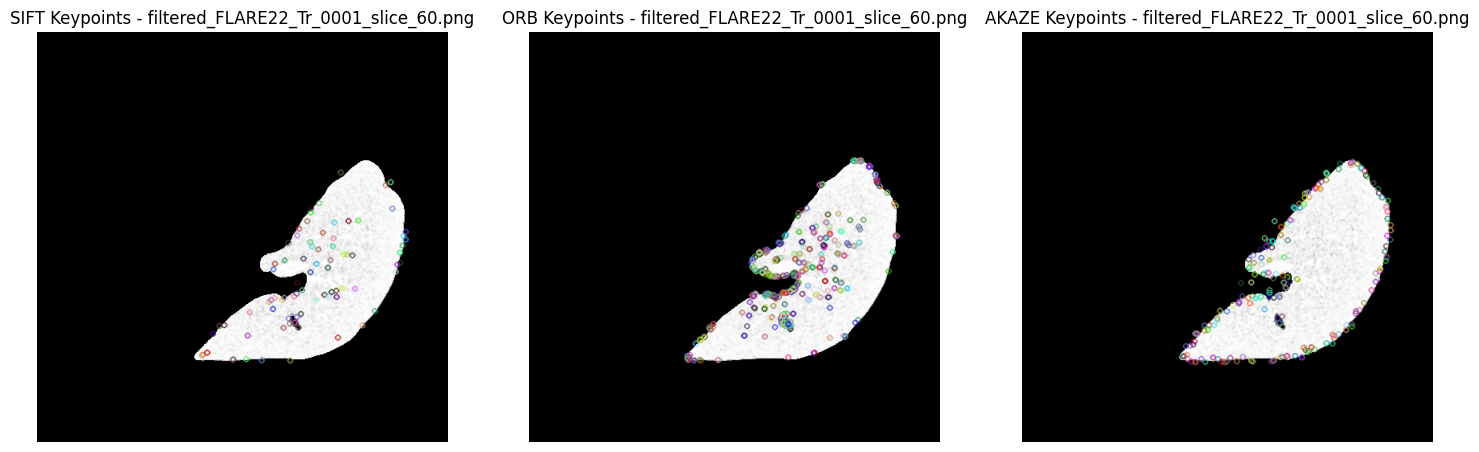

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_60


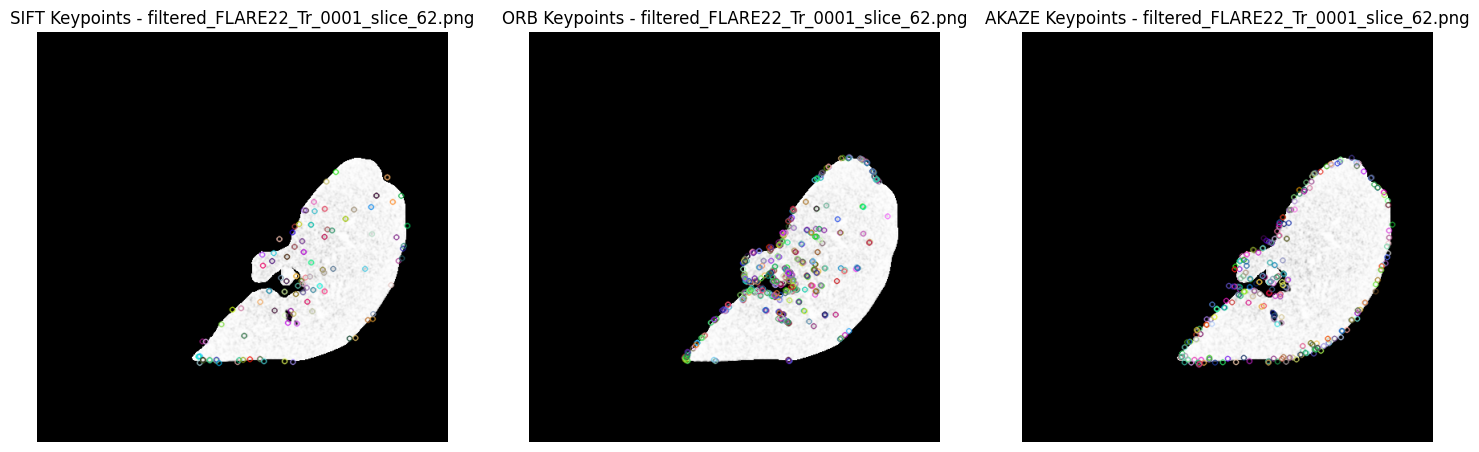

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_62


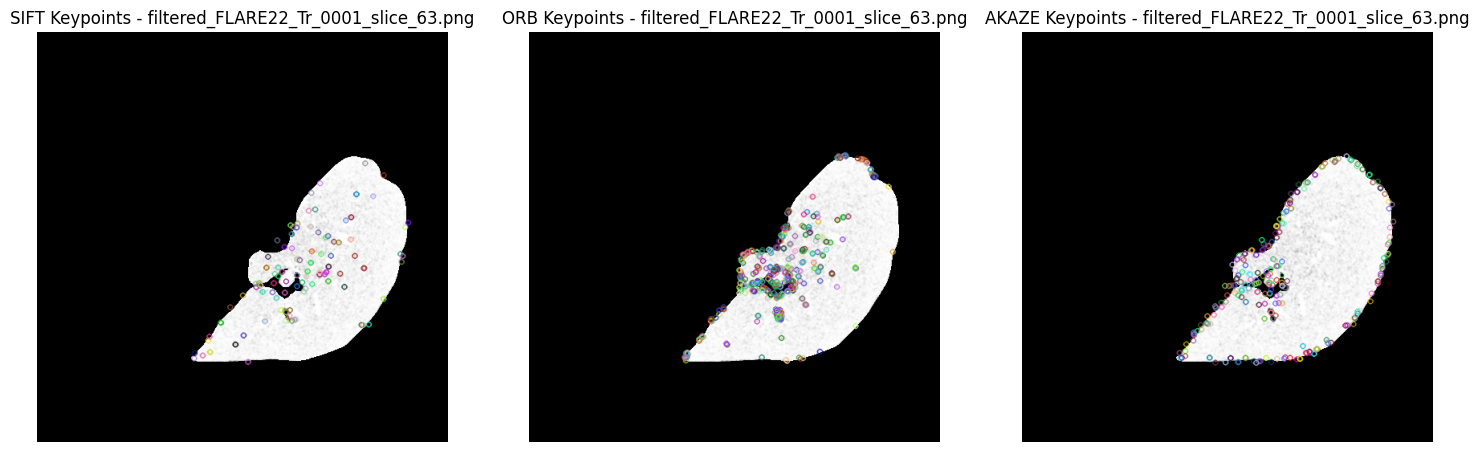

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_63


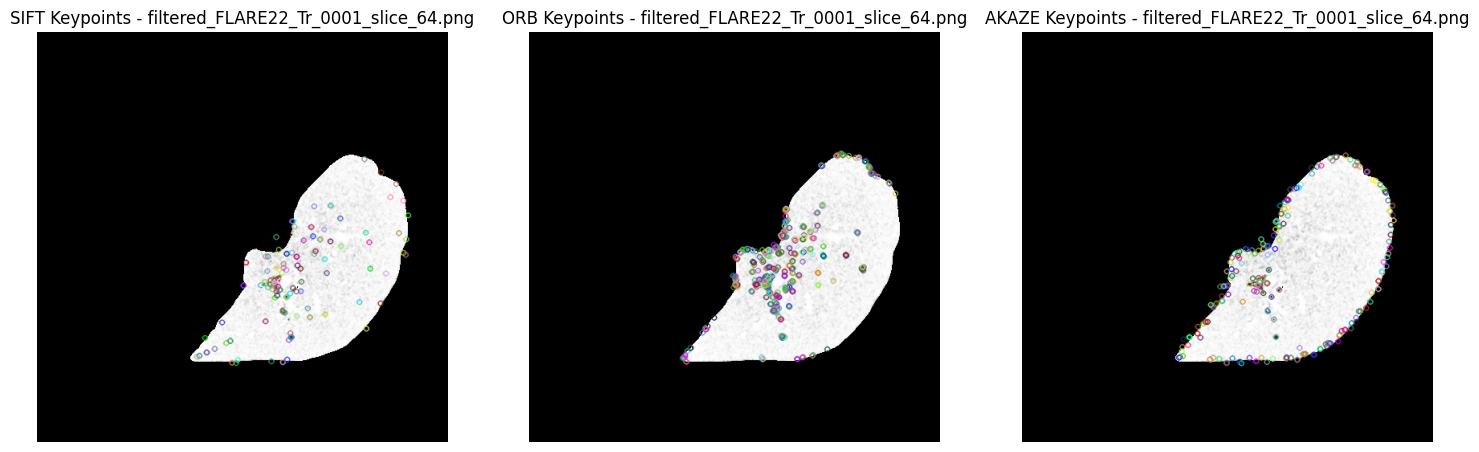

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_64


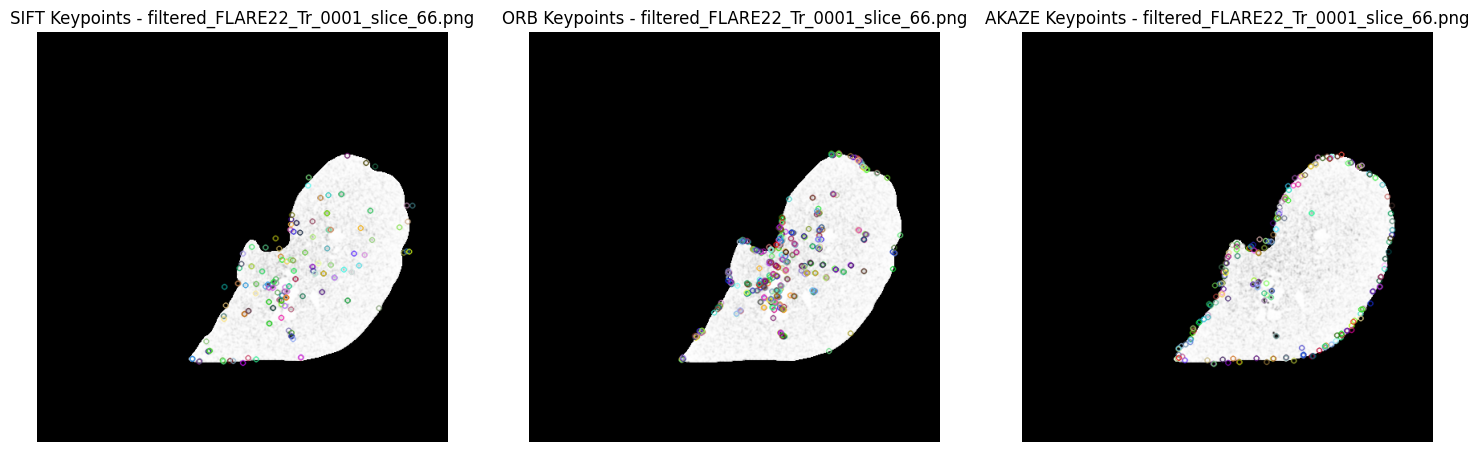

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_66


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Görsel dosya yolları
image_paths = [
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_62.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_63.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_64.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_66.png'
]

# AKAZE, ORB, SIFT algoritmalarını başlat
akaze = cv2.AKAZE_create()
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

# Kaydedilecek dizinleri kontrol et ve oluştur
output_directory = '/mnt/data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Her bir görsel için işlemi uygula
for image_path in image_paths:
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Anahtar noktaları ve tanımlayıcıları tespit et
    keypoints_sift, descriptors_sift = sift.detectAndCompute(image, None)
    keypoints_orb, descriptors_orb = orb.detectAndCompute(image, None)
    keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(image, None)

    # Anahtar noktaları görüntü üzerinde işaretle
    image_with_keypoints_sift = cv2.drawKeypoints(image, keypoints_sift, None)
    image_with_keypoints_orb = cv2.drawKeypoints(image, keypoints_orb, None)
    image_with_keypoints_akaze = cv2.drawKeypoints(image, keypoints_akaze, None)

    # Görselleri yan yana göster
    plt.figure(figsize=(18, 6))

    # SIFT Görseli
    plt.subplot(1, 3, 1)
    plt.imshow(image_with_keypoints_sift)
    plt.title(f"SIFT Keypoints - {image_path.split('/')[-1]}")
    plt.axis('off')

    # ORB Görseli
    plt.subplot(1, 3, 2)
    plt.imshow(image_with_keypoints_orb)
    plt.title(f"ORB Keypoints - {image_path.split('/')[-1]}")
    plt.axis('off')

    # AKAZE Görseli
    plt.subplot(1, 3, 3)
    plt.imshow(image_with_keypoints_akaze)
    plt.title(f"AKAZE Keypoints - {image_path.split('/')[-1]}")
    plt.axis('off')

    plt.show()

    # Kaydedilecek dosya yolları
    base_filename = image_path.split('/')[-1].replace('.png', '')

    # Anahtar noktaları görsellerini kaydet
    output_keypoints_sift_path = os.path.join(output_directory, f'{base_filename}_keypoints_sift.png')
    cv2.imwrite(output_keypoints_sift_path, image_with_keypoints_sift)

    output_keypoints_orb_path = os.path.join(output_directory, f'{base_filename}_keypoints_orb.png')
    cv2.imwrite(output_keypoints_orb_path, image_with_keypoints_orb)

    output_keypoints_akaze_path = os.path.join(output_directory, f'{base_filename}_keypoints_akaze.png')
    cv2.imwrite(output_keypoints_akaze_path, image_with_keypoints_akaze)

    # Tanımlayıcıları kaydet
    output_descriptors_sift_path = os.path.join(output_directory, f'{base_filename}_descriptors_sift.npy')
    np.save(output_descriptors_sift_path, descriptors_sift)

    output_descriptors_orb_path = os.path.join(output_directory, f'{base_filename}_descriptors_orb.npy')
    np.save(output_descriptors_orb_path, descriptors_orb)

    output_descriptors_akaze_path = os.path.join(output_directory, f'{base_filename}_descriptors_akaze.npy')
    np.save(output_descriptors_akaze_path, descriptors_akaze)

    print(f"Keypoints and descriptors saved for {base_filename}")
